In [1]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json
from lib import *
from show_lib import *

In [2]:
%load_ext autoreload
%autoreload 2

**Experiment 1**

$$
\textbf{MINLP}: 
\min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
F(\textbf{x}, \textbf{u}, \textbf{i}), \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f(x(k), u(k), i(k)) \\
\textbf{i} \in P \cap \mathbb{Z}^{N} \\
\end{array} \right.
$$

* variables
    * $\textbf{x} = (x(0), x(1), \dots, x(N))$
    * $\textbf{u} = (u(0), u(1), \dots, u(N-1))$
    * $\textbf{i} = (i(0), i(1), \dots, i(N-1))$

* objective function $
F(\textbf{x}, \textbf{u}, \textbf{i}) = 
\sum\limits^{N}_{k=0} F(x(k), u(k), i(k))
$, where
$
F(x, u, i) = 
\frac{1}{2} \| F_1(x, u, i) \|^2_2
$ and 
$
F_1(x, u, i) = 
(x - x_{ref}, 0, 0)
$
* equality function $
f(x, u, i) = x^3 - i
$
* polygon $
P = 
\left\{ \textbf{i} \in [0, 1]^N \ \bigg| \ \begin{align} 
    & i(k) \geq i(k-1) - i(k-2) \\
    & i(k) \geq i(k-1) - i(k-3) 
\end{align} \right\}
$
* parameters $
N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7$

Define parameters and functions:

In [4]:
N = 30
time_step = 0.05
x_0 = 0.8
x_ref = 0.7

In [5]:
# Differential equation:
def f(x, u, i):
    return x - i

# Path inequality constraints:
def h(x, u, i):
    return x - x

# Objective function
def F1(x, u, i):
    return x - x_ref

def F(x, u, i):
    return 0.5 * (F1(x, u, i) ** 2)

### Solution 1 : GEKKO

Exact integer solution from GEKKO - **branch-and-bound method**.

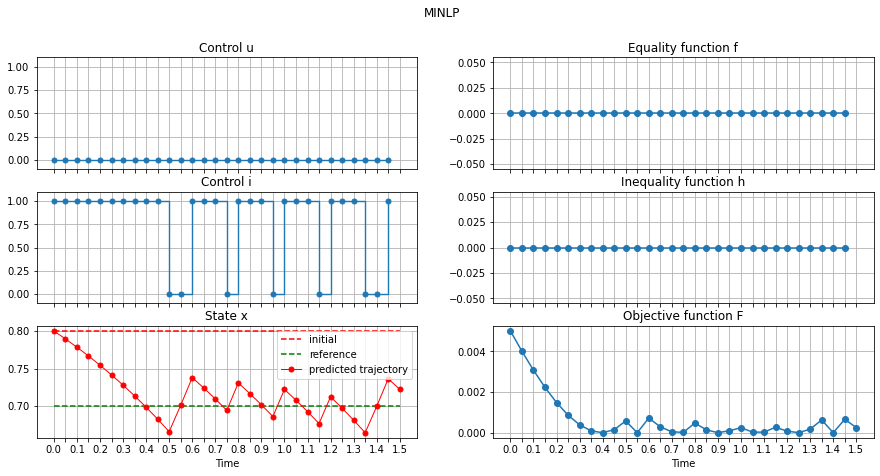

Objective value: 0.0170150392


In [6]:
options = [
    'minlp_maximum_iterations 5000', # 10.000
    'minlp_max_iter_with_int_sol 500', # 500
    'minlp_as_nlp 0', # 1
    'minlp_branch_method 2', # 3
    'minlp_gap_tol 0.0005', # 0.01
    'minlp_integer_tol 0.005', # 0.01
]

history_minlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=True, name='MINLP')
show_results(history_minlp)

*Actually it's not the best solution, because there is at least one better:

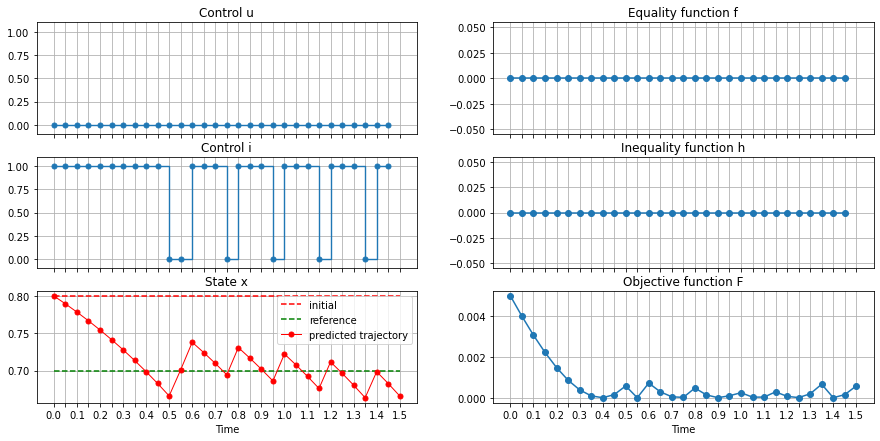

Objective value: 0.0169013675


In [8]:
const_i = [0.0] + [1.0] * 10 + [0.0] * 2 + ([1.0] * 3 + [0.0] * 1) * 4 + [1.0] * 2
assert len(const_i) == N + 1

history_miqp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, 
                                   integer=True, const=True, const_i=const_i)
show_results(history_miqp)

### Solution 2 : Gauss-Newton algorithm

**S1**: solve it without integrality constraint $\textbf{i} \in \mathbb{Z}^{n_i}$.

$$
\textbf{NLP}: 
\min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
F(\textbf{x}, \textbf{u}, \textbf{i}), \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f(x(k), u(k), i(k)) \\
\textbf{i} \in P \\
\end{array} \right.
$$

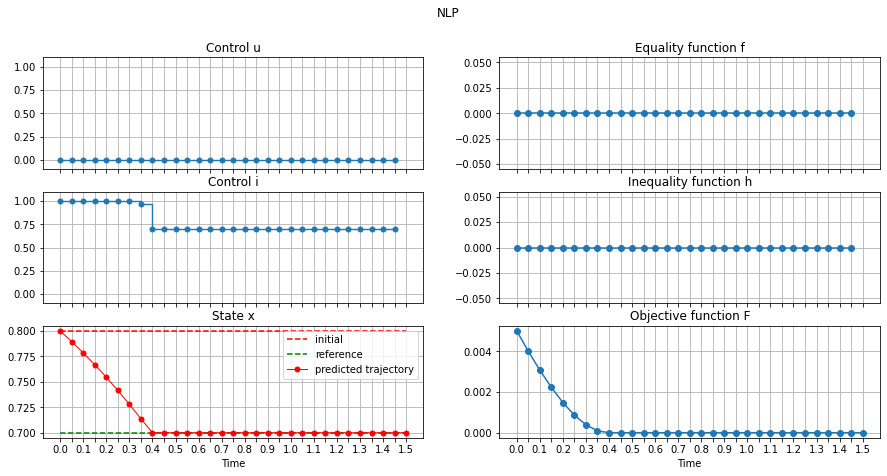

Objective value: 0.0121292875


In [9]:
history_nlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=False, name='NLP')
show_results(history_nlp)

**S2**: approximate our continuous solution $(\textbf{x}^*, \textbf{u}^*, \textbf{i}^*)$ by an integer $(\textbf{x}^{**}, \textbf{u}^{**}, \textbf{i}^{**})$ with the **dist** function.


$$
\textbf{DIST}: 
\min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
F_{GN}(\textbf{x}, \textbf{u}, \textbf{i} \mid 
\textbf{x}^*, \textbf{u}^*, \textbf{i}^*)
, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f_L(x(k), u(k), i(k)) \\
\textbf{i} \in P \cap \mathbb{Z}^{N \cdot n_i}
\end{array} \right.
$$

Objective function:
$
F_{GN}(\textbf{x}, \textbf{u}, \textbf{i} \mid 
\textbf{x}^*, \textbf{u}^*, \textbf{i}^*) = 
\sum\limits^{N}_{k=0} 
F_{GN}(x(k), u(k), i(k) \mid 
x^*(k), u^*(k), i^*(k))
$, where

* $
F_{GN}(x, u, i \mid x^*, u^*, i^*) = 
F_{QP}(x, u, i \mid x^*, u^*, i^*, B_{GN})
$

* $
F_{QP}(x, u, i \mid x^*, u^*, i^*, B) = 
F_{L}(x, u, i \mid x^*, u^*, i^*) + 
\frac{1}{2} 
\begin{bmatrix} 
    x - x^* \\ 
    u - u^* \\
    i - i^* 
\end{bmatrix}^T
B
\begin{bmatrix}
    x - x^* \\ 
    u - u^* \\
    i - i^* 
\end{bmatrix}
$

* $
B_{GN}(x^*, u^*, i^*) = 
\frac{\partial F_1}{\partial (x, u, i)}(x^*, u^*, i^*)
\left(\frac{\partial F_1}{\partial (x, u, i)}(x^*, u^*, i^*)\right)^T
$
  
* $
F_{L}(x, u, i \mid x^*, u^*, i^*) = 
F(x^*, u^*, i^*) + \frac{\partial F}{\partial (x, u, i)}(x^*, u^*, i^*)
((x, u, i) - (x^*, u^*, i^*))
$

  
Equality function 
$
f_{L}(x, u, i \mid x^*, u^*, i^*) = 
f(x^*, u^*, i^*) + \frac{\partial f}{\partial (x, u, i)}(x^*, u^*, i^*)
((x, u, i) - (x^*, u^*, i^*))
$

In [10]:
x_nlp = history_nlp['x']
u_nlp = history_nlp['u']
i_nlp = history_nlp['i']

f_L  = lambda x, x0: linear(f, x, x0)
h_L  = lambda x, x0: linear(h, x, x0)
F_L  = lambda x, x0: linear(F, x, x0)
F_QP = lambda x, x0: gauss_newton(F, F1, x, x0)
F_GN = lambda x, x0: F_QP(x, x0)

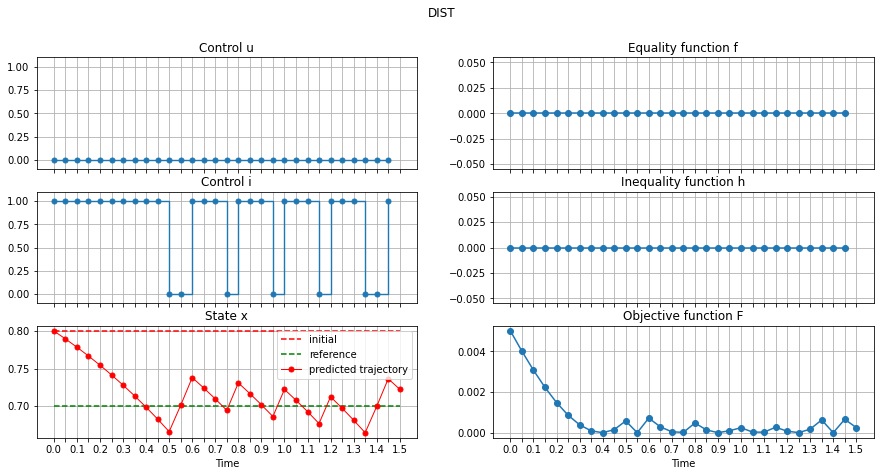

Objective value: 0.0170137566


In [11]:
history_dist = run_optimal_control_dist(x_0, x_ref, x_nlp, u_nlp, i_nlp, N, 
                                        time_step, f_L, h_L, F_GN, options, F, 'DIST')
show_results(history_dist)

In [12]:
y_x0  = history_dist['F0']
y_x   = history_dist['F']
y_x_g = history_dist['F_GN']

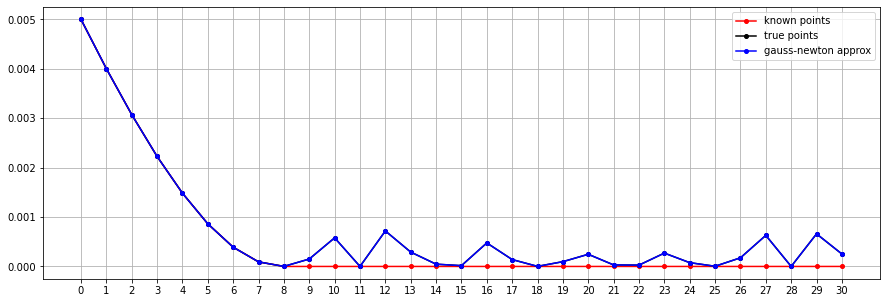

In [13]:
plt.figure(figsize=(15, 5))

time = range(N+1)
plt.plot(time, y_x0, '-o', markersize=4, c='red', label='known points')
plt.plot(time, y_x, '-o', markersize=4, c='black', label='true points')
plt.plot(time, y_x_g, '-o', markersize=4, c='blue', label='gauss-newton approx')

plt.xticks(time)
plt.grid()
plt.legend()

plt.show()

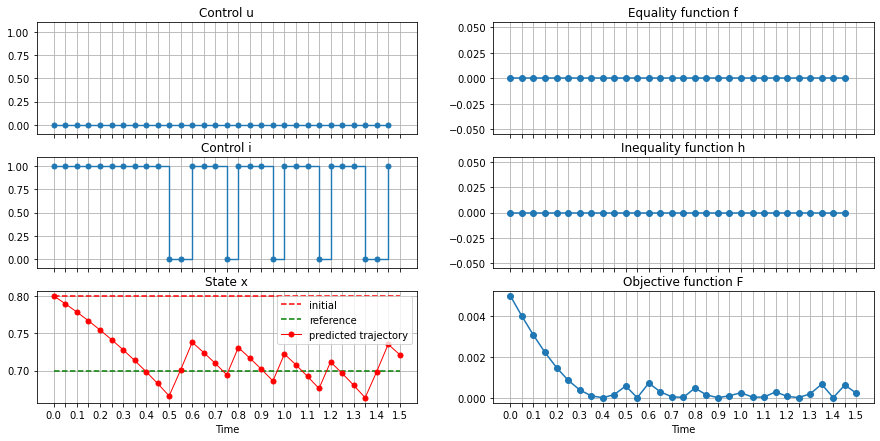

Objective value: 0.0170187900


In [9]:
history_miqp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=True, 
                                   const=True, const_i=history_dist['i'])
show_results(history_miqp)

In [13]:
compare_final_obj(history_minlp, history_miqp)

MIQP  solution: 0.01702
MINLP solution: 0.01702
Difference: -0.00000 - negative => MIQP is worse than MINLP


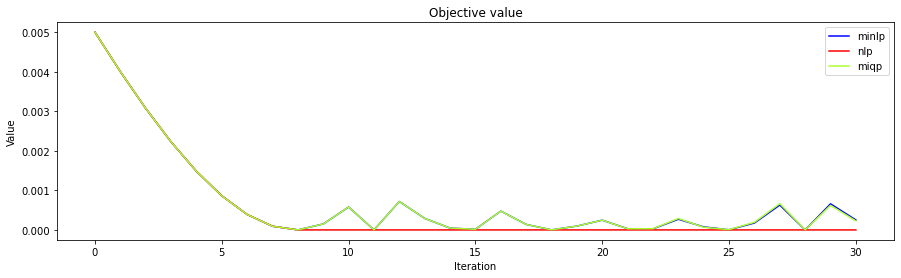

In [14]:
compare_obj_trajectory(history_minlp, history_nlp, history_dist, history_miqp)

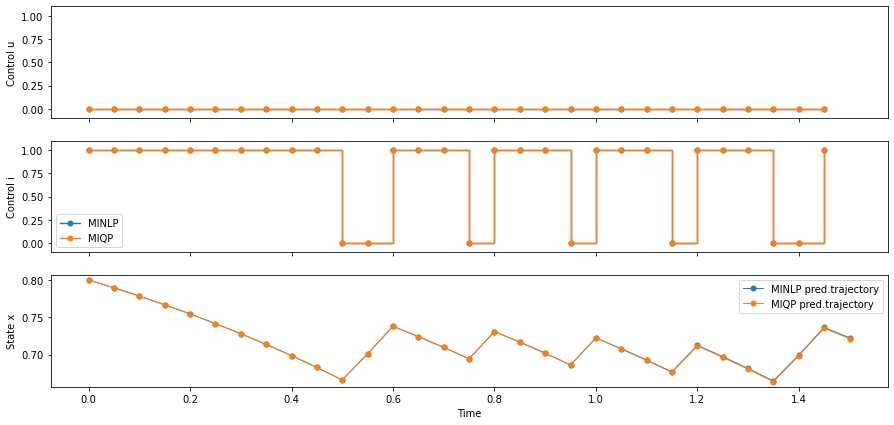

In [15]:
compare_var_trajectory(history_minlp, history_miqp)

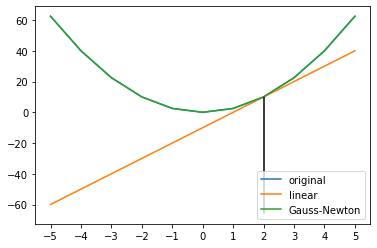

In [15]:
# def linear(f, x, x0):
#     f_grad = optimize.approx_fprime(x0, f, 1e-6)
#     delta = x - x0
#     return f(x0) + np.dot(f_grad, delta)

# def quadratic(f, x, x0, B):
#     f_linear = linear(f, x, x0)
#     delta = x - x0
#     return f_linear + 0.5 * delta @ B @ delta

# def b_gn(f, x, x0):
#     f_grad = optimize.approx_fprime(x0, f, 1e-6)
#     return f_grad @ f_grad.T

# def gauss_newton(f, f1, x, x0):
#     B_GN = b_gn(f1, x, x0)
#     return quadratic(f, x, x0, B_GN)

# d = 5
# x0 = np.array([2.0]*d)
# x_ = np.linspace(-5, 5, 11)
# x = np.array([x_]*d).T
# B = np.eye(d)

# f_1 = lambda x: x
# f_0 = lambda x: 0.5 * sum(f_1(x) ** 2)
# f_l = lambda x, x0: linear(f_0, x, x0)
# f_g = lambda x, x0: gauss_newton(f_0, f_1, x, x0)

# y_0 = [f_0(x_i) for x_i in x]
# y_l = [f_l(x_i, x0) for x_i in x]
# y_g = [f_g(x_i, x0) for x_i in x]
    
# plt.plot(x_, y_0, label='original')
# plt.plot(x_, y_l, label='linear')
# plt.plot(x_, y_g, label='Gauss-Newton')
# plt.xticks(x_)
# _, _, ymin, ymax = plt.axis()
# plt.vlines(x0[0], ymin, f_0(x0), colors='black')
# plt.legend()
# plt.show()

In [ ]:
# N = 5
# d = 3

# a_1d = np.linspace(-5, 5, N)
# a_nd = np.array([a_1d]*d).T
# x_nd = a_nd + 1.5 #np.random.rand(N, 1) * 2
# x_1d = x_nd[:, 0]
# xand = list(zip(x_nd, a_nd))

# f_1 = lambda x, u, i: np.array([x, u, i])
# f_0 = lambda x, u, i: 0.5 * sum(f_1(x, u, i) ** 2)
# f_l = lambda x, x0: linear(f_0, x, x0)
# f_g = lambda x, x0: gauss_newton(f_0, f_1, x, x0)

# ya_0 = [f_0(*a) for x, a in xand]
# yx_0 = [f_0(*x) for x, a in xand]
# y_l = [f_l(x, a) for x, a in xand]
# y_g = [f_g(x, a) for x, a in xand]

# xa = np.hstack([x_1d, a_1d])
# yxa = np.array(yx_0 + ya_0)
# idx = np.argsort(xa)
# xa, yxa = xa[idx], yxa[idx]

# plt.figure(figsize=(15, 5))
# plt.plot(xa, yxa, '--', c='black', alpha=0.7, label='f')

# plt.scatter(a_1d, ya_0, c='red', label='known points')
# plt.scatter(x_1d, yx_0, c='black', label='true points')
# plt.scatter(x_1d, y_l, c='green', label='linear approx')
# plt.scatter(x_1d, y_g, c='blue', label='gauss-newton approx')

# _, _, ymin, ymax = plt.axis()
# plt.ylim(ymin, ymax+0.1)
# plt.xticks(x_1d)

# for n in range(N):
#     plt.plot([a_1d[n], x_1d[n]], [ya_0[n], y_l[n]], c='black')
#     plt.vlines(x_1d[n], ymin, yx_0[n], linestyles='--', colors='black', alpha=0.7)

# plt.legend()
# plt.show()